In [1]:
# import json
# import geojson
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# with open('intermediate_file_paths.json') as output_path_file:
#     output_paths = json.load(output_path_file)

# SI_PER_FIRE_INPUT_PATH = output_paths.get('stage1_si_per_fire_csv')
# SCALED_SI_PER_YEAR_INPUT_PATH = output_paths.get('stage2_scaled_si_per_year_csv')

# # Load dataset
# yearly_smoke_impact_df = pd.read_csv(SCALED_SI_PER_YEAR_INPUT_PATH)
# si_per_fire_df = pd.read_csv(SI_PER_FIRE_INPUT_PATH)

/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_58617/2409978313.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Years with NaN values: [2021]
52.782934279853016
Q1: 16.74033345730031, Q3: 34.60592853216895, IQR: 17.865595074868644
41.381605819145946
    scaled_avg_daily_smoke_impact  year  total_acres_burned  fire_year  \
0                       13.223345  1985        1.485882e+05     1985.0   
3                       22.046619  1988        3.646471e+05     1988.0   
4                       13.755830  1989        9.559396e+04     1989.0   
5                        8.653858  1990        7.796472e+04     1990.0   
7                       10.522113  1992        6.715140e+04     1992.0   
8                       13.372834  1993        1.669350e+05     1993.0   
9                       24.890273  1994        3.350621e+05     1994.0   
10                       9.156539  1995        1.789948e+05     1995.0   
11                      41.381606  1996        8.200648e+05     1996.0   
12                      13.160343  1997        1.488227e+05     1997.0   
13                      16.820036  1998        5

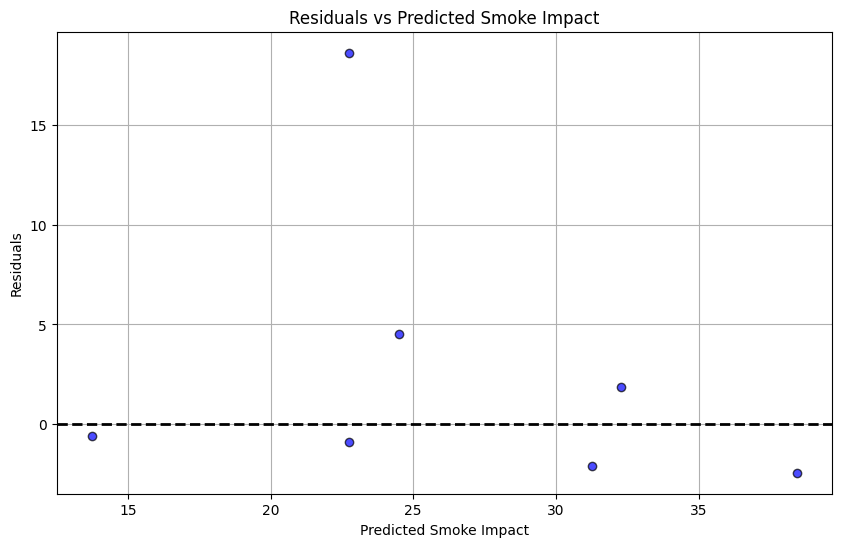

In [3]:
# %% [markdown]
# ## Update to include info about calculation steps

# %%
import json
import geojson
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

with open('intermediate_file_paths.json') as output_path_file:
    output_paths = json.load(output_path_file)

SI_PER_FIRE_INPUT_PATH = output_paths.get('stage1_si_per_fire_csv')
SCALED_SI_PER_YEAR_INPUT_PATH = output_paths.get('stage2_scaled_si_per_year_csv')

# Load dataset
yearly_smoke_impact_df = pd.read_csv(SCALED_SI_PER_YEAR_INPUT_PATH)
si_per_fire_df = pd.read_csv(SI_PER_FIRE_INPUT_PATH)

# Define weights for 'total_acres_burned' and 'distance'
weights = {'total_acres_burned': 1, 'distance': 1}

# Calculate the average distance per year
avg_dist_df = si_per_fire_df.groupby('fire_year').agg(
    avg_dist_from_city=('distance', 'mean')
).reset_index()

# Filter data to include only years after 1984
yearly_smoke_impact_filtered_df = yearly_smoke_impact_df[yearly_smoke_impact_df['year'] > 1984]
filtered_avg_dist_df = avg_dist_df[avg_dist_df['fire_year'] > 1984]

# Prepare data for prediction using original data (without moving average)
combined_df = yearly_smoke_impact_filtered_df[['scaled_avg_daily_smoke_impact', 'year', 'total_acres_burned']].merge(
    filtered_avg_dist_df[['fire_year', 'avg_dist_from_city']],
    left_on='year', right_on='fire_year', how='left'
)

# Apply weights to the relevant predictor variables
combined_df['total_acres_burned_weighted'] = combined_df['total_acres_burned'] * weights['total_acres_burned']
combined_df['distance_weighted'] = combined_df['avg_dist_from_city'] * weights['distance']

# Identify which years have NaN values
na_years = combined_df[combined_df.isna().any(axis=1)]['year'].unique()
print(f"Years with NaN values: {na_years}")

print(combined_df['scaled_avg_daily_smoke_impact'].max())

# Remove outliers using Interquartile Range (IQR) method
Q1 = combined_df['scaled_avg_daily_smoke_impact'].quantile(0.25)
Q3 = combined_df['scaled_avg_daily_smoke_impact'].quantile(0.75)
IQR = Q3 - Q1

print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}')
# combined_df = combined_df[(combined_df['scaled_avg_daily_smoke_impact'] >= (Q1 - 1.2 * IQR)) & 
#                           (combined_df['scaled_avg_daily_smoke_impact'] <= (Q3 + 1.2 * IQR))]

combined_df = combined_df[(combined_df['scaled_avg_daily_smoke_impact'] >= (Q1 - 0.5 * IQR)) & 
                          (combined_df['scaled_avg_daily_smoke_impact'] <= (Q3 + 0.5 * IQR))]

# Remove rows with NaN values in features or labels
combined_df = combined_df.dropna()

print(combined_df['scaled_avg_daily_smoke_impact'].max())

# Check if there are enough samples left after filtering
if combined_df.shape[0] == 0:
    raise ValueError("No samples left after filtering for outliers and NaN values. Consider relaxing the filtering criteria.")

# Normalize total acres burned and distance
combined_df['total_acres_burned_normalized'] = combined_df['total_acres_burned'] / combined_df['total_acres_burned'].max()
combined_df['distance_normalized'] = combined_df['avg_dist_from_city'] / 650

print(combined_df)

# Prepare the features and target variable
features = combined_df[['total_acres_burned_normalized', 'distance_normalized']]
labels = combined_df['scaled_avg_daily_smoke_impact'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Create and train the Gradient Boosting Regressor with Bootstrapping and K-Fold Cross-Validation
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)



# Bootstrapping
bootstrap_iterations = 100
bootstrap_mse_scores = []
bootstrap_r2_scores = []

for _ in range(bootstrap_iterations):
    X_resampled, y_resampled = resample(features, labels, random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = cross_val_score(model, X_resampled, y_resampled, cv=kf, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X_resampled, y_resampled, cv=kf, scoring='r2')
    bootstrap_mse_scores.append(-np.mean(mse_scores))
    bootstrap_r2_scores.append(np.mean(r2_scores))

print(f"Bootstrapped Cross-Validation Mean Squared Error (MSE): {np.mean(bootstrap_mse_scores)}")
print(f"Bootstrapped Cross-Validation R-squared (R2): {np.mean(bootstrap_r2_scores)}")

# Fit the model on the training data
model.fit(X_train, y_train)


# Predict smoke estimates for the test set
y_pred = model.predict(X_test)

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', edgecolors='k', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel('Predicted Smoke Impact')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Smoke Impact')
plt.grid(True)
plt.show()
